In [2]:
from google.colab import files
uploaded = files.upload()


Saving reviews_clean.csv to reviews_clean.csv


In [3]:
!pip -q install scikit-learn tensorflow matplotlib seaborn


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

PROC_PATH = "reviews_clean.csv"

df = pd.read_csv(PROC_PATH)
df = df.dropna(subset=["text_clean", "label"])
df["text_clean"] = df["text_clean"].astype(str)
df["label"] = df["label"].astype(str)

label2id = {"negative": 0, "neutral": 1, "positive": 2}
id2label = {v:k for k,v in label2id.items()}
df["y"] = df["label"].map(label2id)

X_train, X_test, y_train, y_test = train_test_split(
    df["text_clean"], df["y"], test_size=0.2, random_state=42, stratify=df["y"]
)

print(df["label"].value_counts())
len(X_train), len(X_test)


label
positive    32316
neutral      1532
negative      812
Name: count, dtype: int64


(27728, 6932)

In [11]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_VOCAB = 50000
MAX_LEN   = 120

tok = Tokenizer(num_words=MAX_VOCAB, oov_token="<unk>")
tok.fit_on_texts(X_train)

Xtr = tok.texts_to_sequences(X_train)
Xte = tok.texts_to_sequences(X_test)

Xtr = pad_sequences(Xtr, maxlen=MAX_LEN, padding="post", truncating="post")
Xte = pad_sequences(Xte, maxlen=MAX_LEN, padding="post", truncating="post")

ytr = np.array(y_train)
yte = np.array(y_test)

vocab_size = min(MAX_VOCAB, len(tok.word_index) + 1)
vocab_size


11139

In [14]:
from sklearn.model_selection import train_test_split

# Split train into (train + validation)
X_train, X_val, y_train, y_val = train_test_split(
    Xtr, ytr, test_size=0.1, random_state=42, stratify=ytr
)

X_test = Xte
y_test = yte


In [15]:
from sklearn.utils.class_weight import compute_class_weight

classes = np.array([0,1,2])  # neg, neu, pos
cw = compute_class_weight(class_weight='balanced', classes=classes, y=ytr)
class_weight = {i: w for i, w in enumerate(cw)}
class_weight


{0: np.float64(14.21948717948718),
 1: np.float64(7.545034013605442),
 2: np.float64(0.35750847741719205)}

In [16]:
import tensorflow as tf
from tensorflow.keras import layers, models

EMB_DIM = 128
LSTM_UNITS = 128
DROPOUT = 0.3
LR = 2e-3

model = tf.keras.Sequential([
    layers.Embedding(input_dim=vocab_size, output_dim=EMB_DIM, input_shape=(MAX_LEN,)),
    layers.Bidirectional(layers.LSTM(LSTM_UNITS, return_sequences=False)),
    layers.Dropout(DROPOUT),
    layers.Dense(64, activation="relu"),
    layers.Dropout(DROPOUT),
    layers.Dense(3, activation="softmax"),
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.summary()



/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 120, 128)       │     1,425,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,705,603 (6.51 MB)

 Trainable params: 1,705,603 (6.51 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=256,
)


Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.8971 - loss: 0.3497 - val_accuracy: 0.9322 - val_loss: 0.1946
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.9463 - loss: 0.1642 - val_accuracy: 0.9391 - val_loss: 0.1805
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9523 - loss: 0.1452 - val_accuracy: 0.9394 - val_loss: 0.1880
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9630 - loss: 0.1156 - val_accuracy: 0.9322 - val_loss: 0.2054
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.9714 - loss: 0.0938 - val_accuracy: 0.9326 - val_loss: 0.2296
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9734 - loss: 0.0871 - val_accuracy: 0.9322 - val_loss: 0.2659
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9797 - loss: 0.0686 - val_accuracy: 0.9272 - val_loss: 0.2821
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.9827 - loss: 0.0604 - val_accuracy: 0.9272 - v

Accuracy: 0.9255626081938835
              precision    recall  f1-score   support

    negative     0.5735    0.2407    0.3391       162
     neutral     0.2863    0.2313    0.2559       307
    positive     0.9531    0.9757    0.9643      6463

    accuracy                         0.9256      6932
   macro avg     0.6043    0.4826    0.5198      6932
weighted avg     0.9147    0.9256    0.9183      6932



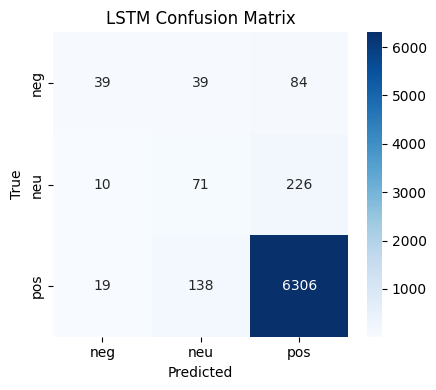

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

probs = model.predict(Xte, verbose=0)
preds = probs.argmax(axis=1)

print("Accuracy:", (preds == yte).mean())
print(
    classification_report(
        yte, preds, target_names=["negative","neutral","positive"], digits=4
    )
)

cm = confusion_matrix(yte, preds, labels=[0,1,2])
plt.figure(figsize=(4.5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["neg","neu","pos"],
            yticklabels=["neg","neu","pos"])
plt.title("LSTM Confusion Matrix")
plt.ylabel("True")
plt.xlabel("Predicted")
plt.tight_layout()
plt.show()


In [20]:
import os, json, joblib, pandas as pd
os.makedirs("outputs/charts", exist_ok=True)
os.makedirs("models", exist_ok=True)

# Save model
model.save("models/lstm_sentiment")

# Save tokenizer
joblib.dump(tok, "models/keras_tokenizer.joblib")

# Save confusion matrix plot
plt.figure(figsize=(4.5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["neg","neu","pos"],
            yticklabels=["neg","neu","pos"])
plt.title("LSTM Confusion Matrix")
plt.ylabel("True")
plt.xlabel("Predicted")
plt.tight_layout()
plt.savefig("outputs/charts/confusion_matrix_lstm.png")
plt.close()


ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=models/lstm_sentiment.

In [ ]:
from google.colab import files
files.download("outputs/charts/confusion_matrix_lstm.png")
files.download("outputs/lstm_metrics.json")
model.save("models/lstm_sentiment.h5")
files.download("models/lstm_sentiment.h5")
files.download("models/keras_tokenizer.joblib")
